In [2]:
#get larlite
from larlite import larlite as ll
from larlite import larutil as lu

geo=lu.Geometry.GetME()
geoH=lu.GeometryHelper.GetME()

import ROOT

In [3]:
#graphics 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import root_numpy as rn
import pandas as pd
%matplotlib inline

/Library/Python/2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.8.0rc1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [4]:
#create storage manager
sm = ll.storage_manager()
sm.set_io_mode(ll.storage_manager.kREAD)
FILENAME="mcc8_post_pi0cut.root"
sm.add_in_filename(FILENAME)
sm.open()

True

STARTING! 
~~~~~~~~~~~> event is 0 <~~~~~~~~~~~
(151, 7)
                 X              Y              Z      vtx_x      vtx_y  \
0     2.508195e+02  -3.056073e+00   3.273472e+02  74.518898 -33.987915   
1    1.797693e+308  1.797693e+308  1.797693e+308  74.518898 -33.987915   
2     2.419847e+02  -1.026737e+02   2.702115e+02  74.518898 -33.987915   
3    1.797693e+308  1.797693e+308  1.797693e+308  74.518898 -33.987915   
4     1.982515e+02   9.266091e+01   8.357833e+02  74.518898 -33.987915   
5     7.445950e+01  -9.298676e+01   4.544778e+00  74.518898 -33.987915   
6    1.797693e+308  1.797693e+308  1.797693e+308  74.518898 -33.987915   
7     8.391230e+01  -1.289904e+01   5.396243e+02  74.518898 -33.987915   
8     7.031853e+01  -4.562138e+01   5.615574e+02  74.518898 -33.987915   
9    1.797693e+308  1.797693e+308  1.797693e+308  74.518898 -33.987915   
10    1.886174e+02   5.010366e+01   8.570997e+02  74.518898 -33.987915   
11    1.513521e+02   2.054763e+01   8.485293e+02  74.51

/Library/Python/2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: overflow encountered in square


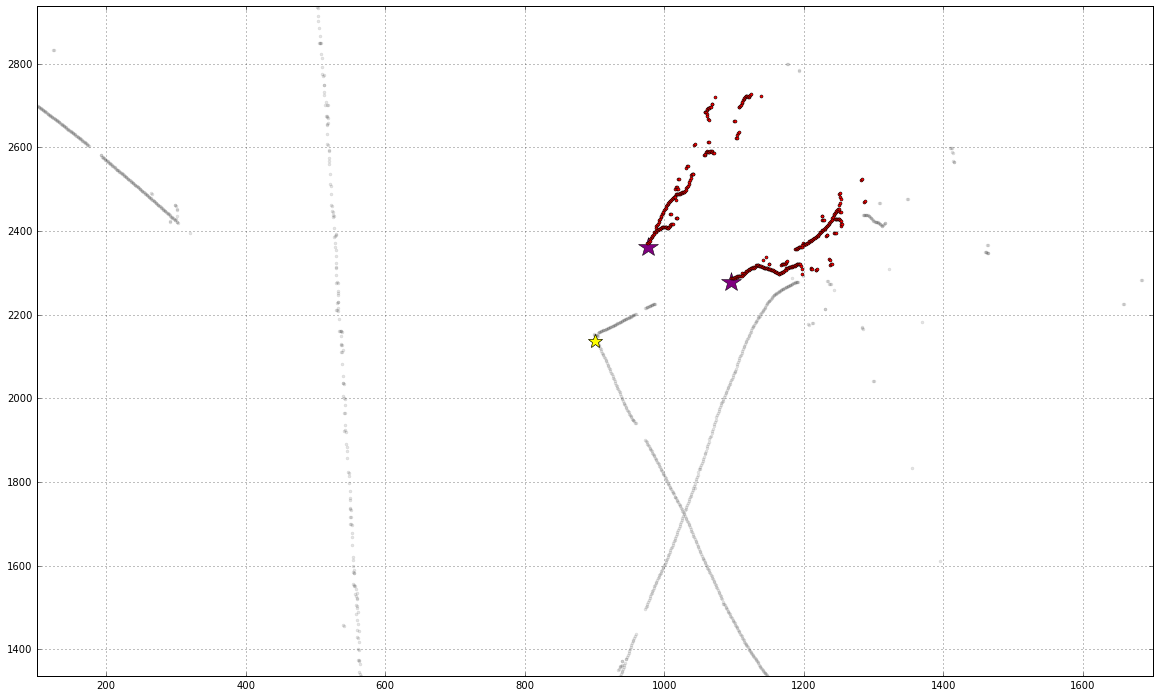

In [19]:
#there is only 1 event
print "STARTING! "
#for evt in xrange(1050):
while True:
    evt = 0
    print "~~~~~~~~~~~> event is %d <~~~~~~~~~~~"%evt
    
    sm.go_to(evt)

    #get hits and clusters
    event_hits     = sm.get_data(ll.data.kHit,"gaushit")
    event_clusters = sm.get_data(ll.data.kCluster,"ImageClusterHit")
    event_showers = sm.get_data(ll.data.kShower,"showerreco")
    event_mcshowers = sm.get_data(ll.data.kMCShower,"mcreco")
    event_vertex = sm.get_data(ll.data.kVertex,"numuCC_vertex")

    #get ass
    event_ass      = sm.get_data(ll.data.kAssociation,"ImageClusterHit")
    #get association
    cluster_to_hit_ass = event_ass.association(event_clusters.id(),event_hits.id())

    mcshowerdata = rn.root2array(FILENAME,
                            treename='mcshower_mcreco_tree',
                            branches=['mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.X()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.Y()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.Z()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.Energy()'])
                                      
    mcs_df= pd.DataFrame({'X'   : mcshowerdata[evt][0],
                          'Y'   : mcshowerdata[evt][1],
                          'Z'   : mcshowerdata[evt][2]})

    vtx=ROOT.std.vector('double')()
    vtx.resize(3)
    vtx[0]=event_vertex[0].X()
    vtx[1]=event_vertex[0].Y()
    vtx[2]=event_vertex[0].Z()

    mcs_df['vtx_x'] = vtx[0]
    mcs_df['vtx_y'] = vtx[1] 
    mcs_df['vtx_z'] = vtx[2] 
    mcs_df['diff'] = np.sqrt( pow(mcs_df.vtx_x.values - mcs_df.X.values,2) + \
                               pow(mcs_df.vtx_y.values - mcs_df.Y.values,2) + \
                               pow(mcs_df.vtx_z.values - mcs_df.Z.values,2) )
    print mcs_df.shape
    print mcs_df
    
    
    
    gausdata = rn.root2array(FILENAME,
                            treename='hit_gaushit_tree',
                            branches=['hit_gaushit_branch.vector<larlite::hit>.fPeakTime',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Wire',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Plane'])

    hits_df= pd.DataFrame({'Wire'      : gausdata[evt][1],
                           'PeakTime'  : gausdata[evt][0],
                           'Plane'     : gausdata[evt][2]})

    
    showerdata = rn.root2array(FILENAME,
                            treename='shower_showerreco_tree',
                            branches=['shower_showerreco_branch.vector<larlite::shower>.fXYZstart.x()',
                                      'shower_showerreco_branch.vector<larlite::shower>.fXYZstart.y()',
                                      'shower_showerreco_branch.vector<larlite::shower>.fXYZstart.z()'])
                                      
    showers_df= pd.DataFrame({'X'   : showerdata[evt][0],
                              'Y'   : showerdata[evt][1],
                              'Z'   : showerdata[evt][2]
                             })


    #Show the ImageClusters
    for plane in [2]: #[0,1,2]:

        fig,ax=plt.subplots(figsize=(10*2,6*2))

        phits = hits_df.query("Plane=={}".format(plane))

        ax.plot(phits.Wire,phits.PeakTime,'o',color='black',markersize=3,alpha=0.1)
    
    
        for i in xrange(showers_df.shape[0]):
            shr=ROOT.std.vector('double')()
            shr.resize(3)
            shr[0]=showers_df.X.values[i]
            shr[1]=showers_df.Y.values[i]
            shr[2]=showers_df.Z.values[i]
            px = geoH.Point_3Dto2D(shr.data(),plane)
            
        for i in xrange(showers_df.shape[0]):
            shr=ROOT.std.vector('double')()
            shr.resize(3)
            shr[0]=showers_df.X.values[i]
            shr[1]=showers_df.Y.values[i]
            shr[2]=showers_df.Z.values[i]
            px = geoH.Point_3Dto2D(shr.data(),plane)
     
       
            pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
            ax.plot(pt[0],pt[1],'*',markersize=20,color='purple')
    
        # plot each cluster and userinfo
        for ix,cluster in enumerate(cluster_to_hit_ass):

            ##############################
            #get the hits for this clusters
            slice_=np.array(cluster)
            if event_clusters[ix].Plane().Plane != plane: continue
            if slice_.size == 0: continue

            hslice = hits_df.iloc[slice_]
            ax.plot(hslice.Wire,hslice.PeakTime,'o',color='red',markersize=3)

#             exec("cluster_data = plane%s"%plane)
            cid = event_clusters[ix].ID()

            #put vertex information on screen as a big star 


            px = geoH.Point_3Dto2D(vtx.data(),plane)
            pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])

            ax.plot(pt[0],pt[1],'*',markersize=15,color='yellow')
            ax.set_xlim(pt[0]-800,pt[0]+800)
            ax.set_ylim(pt[1]-800,pt[1]+800)
            
        plt.grid()
        plt.show()
    break